# Product Classifier [Train model notebook]

## Author: Luis Eduardo Ferro Diez, <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the run as-is code necessary to compute the necessary elements of the project.

In [14]:
reviews_path = "/media/ohtar10/Adder-Storage/datasets/amazon/rev_prod_documents/10m"
n = 1000

## Step 1 - Read data as-is

In [15]:
import pandas as pd

reviews = pd.read_parquet(reviews_path, engine="pyarrow")
reviews.head()

,categories,document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...


In [16]:
documents = reviews[:n]

## Step 1.1 - Transform the data to count documents per category
We have documents that can have multiple categories, we need a transformer that explode these cases so we can count the number of documents per category

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiValueColumnExpander(BaseEstimator, TransformerMixin):
    
    def __init__(self, expand_column, value_split_char=";"):
        self.expand_column = expand_column
        self.value_split_char = value_split_char
        
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        split_fn = lambda x: x.split(";")
        data[self.expand_column] = data[self.expand_column].apply(split_fn)
        return data.explode(self.expand_column)

In [18]:
col_expander = MultiValueColumnExpander(expand_column="categories", value_split_char=";")
expanded_documents = col_expander.transform(documents)
expanded_documents.head()

,categories,document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...


## Step 2 - Pre-process text

In [19]:
def create_tagged_document(row):
    categories = row["categories"]
    document = row["document"]
    tagged_document = TaggedDocument(words=word_tokenize(document), tags=categories.split(";"))
    index = ["categories", "document", "tagged_document"]
    return pd.Series([categories, document, tagged_document], index=index)

In [20]:
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

nltk.download('punkt')

class DocumentTagger(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # Do nothing
    
    def transform(self, X, y=None):
        data = X.copy()
        return data.apply(create_tagged_document, axis=1)

[nltk_data] Downloading package punkt to /home/ohtar10/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
document_tagger = DocumentTagger()
tagged_documents = document_tagger.transform(documents)
tagged_documents.head()

,categories,document,tagged_document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni..."
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu..."
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,..."
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint..."
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre..."


## Step 3 - Train Document Embeddings

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


class Doc2VecWrapper(BaseEstimator, TransformerMixin):
    
    def __init__(self, document_column, tag_doc_column, lr=0.01, epochs=10, vec_size=100, alpha=0.1, min_alpha=0.0001, min_count=1, dm=0):
        self.document_column = document_column
        self.tag_doc_column = tag_doc_column
        self.lr = lr
        self.epochs = epochs
        self.vec_size = vec_size
        self.alpha = alpha
        self.min_alpha = min_alpha
        self.min_count = min_count
        self.dm = dm
    
    def fit(self, X, y=None):
        tagged_documents = X[self.tag_doc_column]
        
        d2v_model = Doc2Vec(vector_size=self.vec_size,
                           alpha=self.alpha,
                           min_alpha=self.min_alpha,
                           min_count=self.min_count,
                           dm=self.dm)
        
        d2v_model.build_vocab(tagged_documents)
        
        for epoch in range(self.epochs):
            d2v_model.train(tagged_documents,
                           total_examples=d2v_model.corpus_count,
                           epochs=d2v_model.epochs)
            d2v_model.alpha -= self.lr
            d2v_model.min_alpha = d2v_model.alpha
        self.d2v_model = d2v_model
        
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        tagged_docs = data[self.document_column].apply(word_tokenize)
        embeddings = tagged_docs.apply(self.d2v_model.infer_vector)
        data["d2v_embedding"] = embeddings
        return data
    
    def save_model(self, save_path):
        self.d2v_model.save(save_path)

In [23]:
%%time
from sklearn.pipeline import Pipeline

d2v_model = Doc2VecWrapper(document_column="document",
                          tag_doc_column="tagged_document",
                          lr=0.0002,
                          epochs=10,
                          vec_size=300,
                          alpha=0.025,
                          min_alpha=0.00025)
d2v_pipeline = Pipeline(
    [
        ("doc_tagger", DocumentTagger()),
        ("d2v_model", d2v_model)
    ]
)

document_embeddings = d2v_pipeline.fit_transform(documents)
document_embeddings.head()

CPU times: user 14.8 s, sys: 140 ms, total: 15 s
Wall time: 9.3 s


,categories,document,tagged_document,d2v_embedding
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni...","[-0.7226991, 1.2661948, 0.3653824, -0.2832556,..."
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu...","[-0.25122574, 0.29246882, 0.15588485, -0.04865..."
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,...","[-0.1914992, 0.12826699, 0.16730285, 0.2095367..."
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint...","[-0.14239962, 0.17992742, 0.04004985, -0.07660..."
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre...","[-0.15240784, -0.17538749, 0.08062677, 0.13433..."


In [24]:
d2v_model.save_model("/tmp/d2v_model.model")

## Step 4 - CNN Preprocess
In this stage we prepar the input information to be feed to the CNN model.

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pickle

class CategoryEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, label_column="categories"):
        self.label_column = label_column
    
    def fit(self, X, y=None):
        data = X.copy()
        categories = data[self.label_column].apply(lambda cat: cat.split(";")).values.tolist()
        category_encoder = MultiLabelBinarizer()
        category_encoder.fit(categories)
        self.category_encoder = category_encoder
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        categories = data[self.label_column].apply(lambda cat: cat.split(";")).values.tolist()
        encoded_categories = self.category_encoder.transform(categories)
        encoded_categories = [arr for arr in encoded_categories]
        data["encoded_category"] = encoded_categories
        return data
    
    def save_model(self, save_path):
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.category_encoder, model_file)

In [26]:
cat_encoder = CategoryEncoder()
doc_embeddings_encoded_cats = cat_encoder.fit_transform(document_embeddings)
doc_embeddings_encoded_cats.head()

,categories,document,tagged_document,d2v_embedding,encoded_category
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...,"([Hifonics, ZRX2000.1D, Car, Amplifier, Hifoni...","[-0.7226991, 1.2661948, 0.3653824, -0.2832556,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...,"([3x, Nokia, Lumia, 521, (, TMobile, ), Premiu...","[-0.25122574, 0.29246882, 0.15588485, -0.04865...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...,"([Cook, !, Collection, Solid, Color, Jacquard,...","[-0.1914992, 0.12826699, 0.16730285, 0.2095367...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...,"([NCAA, VCU, Rams, Ash, Distressed, Logo, Vint...","[-0.14239962, 0.17992742, 0.04004985, -0.07660...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...,"([1Pack, of, 3, Cavilon, Durable, Barrier, Cre...","[-0.15240784, -0.17538749, 0.08062677, 0.13433...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [27]:
cat_encoder.save_model("/tmp/product_category_encoder.sav")

## Step 4 - Train the CNN

In [28]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

s_config = tf.ConfigProto()
#s_config.gpu_options.allow_growth = True
s_config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.keras.backend.set_session(tf.Session(config=s_config))

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ohtar10/miniconda3/envs/wtsp/lib/python3

In [40]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping

class ProductsCNN(BaseEstimator, TransformerMixin):
    
    def __init__(self, features_column, label_column, classes, 
                 vec_size=100, 
                 epochs=100, 
                 batch_size=1000,
                 validation_split=0.2):
        self.features_column = features_column
        self.label_column = label_column
        self.vec_size = vec_size
        self.classes = classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        
    
    def __build_ann_architecture(self):
        # Define the inputs
        embedding_input = Input(shape=(self.vec_size,1), dtype='float32', name='comment_text')

        # Define convolutional layers
        conv = Conv1D(64, 3, activation='tanh', input_shape=(self.vec_size,), kernel_regularizer=regularizers.l2())(embedding_input)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv = Conv1D(128, 3, activation='tanh')(conv)
        conv = SpatialDropout1D(0.2)(conv)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv = Conv1D(128, 3, activation='tanh')(conv)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv = SpatialDropout1D(0.1)(conv)
        conv = Conv1D(64, 3, activation='tanh')(conv)
        conv = MaxPool1D(2, strides=None, padding='valid')(conv)
        conv_output = Flatten()(conv)


        # Define dense layers
        # minimize the dense layers - maybe add one of 64
        x = Dense(128, activation='relu')(conv_output)
        x = Dropout(0.5)(x)

        #And finally make the predictions using the previous layer as input
        main_output = Dense(self.classes, activation='softmax', name='prediction')(x)

        ann_model = Model(inputs=embedding_input, outputs=main_output)
        ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        self.ann_model = ann_model
    
    def fit(self, X, y=None):
        self.__build_ann_architecture()
        X_train = X[self.features_column].values
        X_train = np.array([e for e in X_train])
        y_true = np.array([l for l in y])
        X_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-7, restore_best_weights=True)
        history = self.ann_model.fit(X_rs, y_true, 
                                     epochs=self.epochs, 
                                     batch_size=self.batch_size, 
                                     validation_split=self.validation_split, 
                                     callbacks=[early_stopping])
        self.history = history
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        features = data[self.features_column].values
        features = np.array([e for e in features])
        features = features.reshape(features.shape[0], features.shape[1], 1)
        predictions = self.ann_model.predict(features)
        predictions = [p for p in predictions]
        data["predictions"] = predictions
        return data
    
    def save_model(self, save_path, name=None):
        if not name:
            name = "product_cnn"
        definition_path = f"{save_path}/{name}-def.yaml"
        weights_path = f"{save_path}/{name}-weights.h5"
        
        ann_model_definition = self.ann_model.to_yaml()
        
        with open(definition_path, 'w') as file:
            file.write(ann_model_definition)

        self.ann_model.save_weights(weights_path)

In [41]:
from sklearn.model_selection import train_test_split

y = doc_embeddings_encoded_cats["encoded_category"].values
X_train, X_test, y_train, y_test = train_test_split(doc_embeddings_encoded_cats, y, test_size= 0.3)

In [42]:
%%time
classes = cat_encoder.category_encoder.classes_.shape[0]
products_cnn = ProductsCNN(features_column="d2v_embedding", 
                           label_column="encoded_category", 
                           classes=classes, 
                           vec_size=300)
docs_with_predictions = products_cnn.fit_transform(X_train, y_train)
docs_with_predictions.head()

Train on 560 samples, validate on 140 samples
Epoch 1/100
560/560 [==============================] - 1s 2ms/step - loss: 2.3375 - acc: 0.0750 - val_loss: 2.2605 - val_acc: 0.5214
Epoch 2/100
560/560 [==============================] - 0s 882us/step - loss: 2.2575 - acc: 0.3179 - val_loss: 2.1769 - val_acc: 0.4714
Epoch 3/100
560/560 [==============================] - 0s 847us/step - loss: 2.1802 - acc: 0.3679 - val_loss: 2.0661 - val_acc: 0.4000
Epoch 4/100
560/560 [==============================] - 0s 817us/step - loss: 2.0833 - acc: 0.3571 - val_loss: 1.9454 - val_acc: 0.3071
Epoch 5/100
560/560 [==============================] - 0s 867us/step - loss: 1.9797 - acc: 0.3518 - val_loss: 1.8635 - val_acc: 0.4000
Epoch 6/100
560/560 [==============================] - 0s 832us/step - loss: 1.9362 - acc: 0.3554 - val_loss: 1.8013 - val_acc: 0.5214
Epoch 7/100
560/560 [==============================] - 0s 817us/step - loss: 1.9275 - acc: 0.3679 - val_loss: 1.7270 - val_acc: 0.5286
Epoch 8/100

,categories,document,tagged_document,d2v_embedding,encoded_category,predictions
178,"Technology, Electronics & Accessories",Agent18 IPSX/A ClearShield Hard Case for iPhon...,"([Agent18, IPSX/A, ClearShield, Hard, Case, fo...","[-0.016537337, -0.04880893, 0.08893826, 0.1035...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[2.0465292e-08, 5.677213e-08, 5.6796576e-09, 1..."
778,"Technology, Electronics & Accessories",5A DC 24V Input to 12V Output Power Converter ...,"([5A, DC, 24V, Input, to, 12V, Output, Power, ...","[-0.27645198, -0.7427943, 0.23150367, 0.487865...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5.0581167e-07, 8.888191e-07, 6.076038e-10, 6...."
803,Music,Inspired by time spent trapped in his apartmen...,"([Inspired, by, time, spent, trapped, in, his,...","[-0.07726008, 0.038892422, 0.26269034, 0.20637...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1.0677271e-06, 8.014963e-07, 1.9613873e-08, 1..."
634,"Technology, Electronics & Accessories",Design Collection Hard Phone Cover Case Protec...,"([Design, Collection, Hard, Phone, Cover, Case...","[-0.4115087, -0.28871852, 0.18230014, 0.293161...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[2.2286538e-07, 1.9504753e-07, 6.838896e-10, 6..."
418,Books,The Rights of Law Enforcement Officers\nThis e...,"([The, Rights, of, Law, Enforcement, Officers,...","[-0.056981172, -0.031585637, -0.016171085, -0....","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.99999297, 5.6072105e-07, 1.4746617e-07, 2.5..."


In [43]:
products_cnn.save_model(save_path="/tmp", name="cnn_test")

In [44]:
import matplotlib.pyplot as plt

def plot_history(cnn, 
                 acc='acc', 
                 val_acc='val_acc', 
                 loss='loss', 
                 val_loss='val_loss',
                 save_path=None):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'], fontsize=14)
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'], fontsize=14)
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

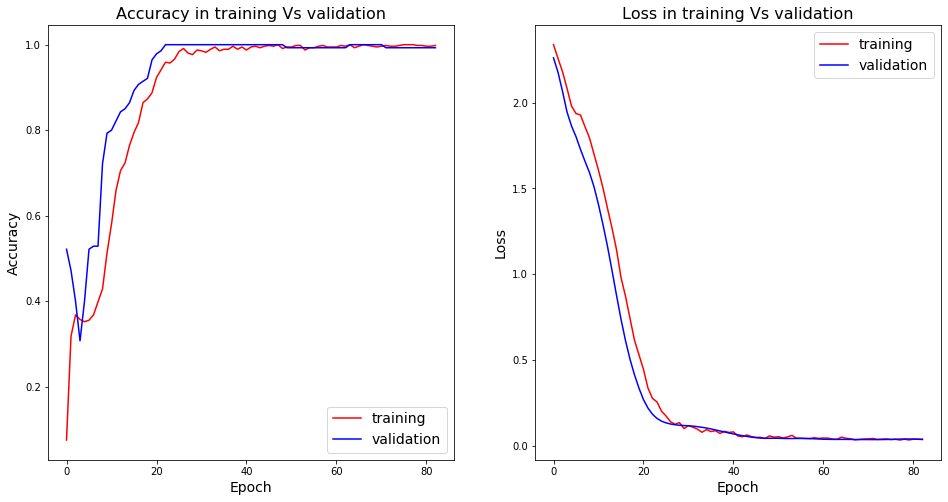

In [45]:
plot_history(products_cnn.history, 
             acc='acc', 
             val_acc='val_acc', 
             loss='loss', 
             val_loss='val_loss',
             save_path="./cnn_train_history.png")

## Step 5 - Validate against the testing set

In [64]:
predictor = products_cnn.ann_model
features = X_test["d2v_embedding"].values
X_test_rs = np.array([e for e in features])
X_test_rs = X_test_rs.reshape(X_test_rs.shape[0], X_test_rs.shape[1], 1)
y_pred = np.where(predictor.predict(X_test_rs) > 0.5, 1., 0.)
y_true = np.array([l for l in y_test])

In [82]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report

classes = ['Books',
 'Clothing, Shoes & Jewelry',
 'Health & Personal Care',
 'Health, Fitness & Dieting',
 'Home & Kitchen',
 'Movies & TV',
 'Music',
 'Office & School Supplies',
 'Technology, Electronics & Accessories',
 'Toys & Games']

acc = accuracy_score(y_true, y_pred)
cm = multilabel_confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)

print(f"Accuracy:\n{acc}\n")

Accuracy:
0.9933333333333333



### Step 5.1 Plot the classification report

In [343]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import re

def plot_classification_report(cr, class_labels, title="Classification Report", cmap="RdYlBu", save_path=None):
    cr = cr.replace("\n\n", "\n")
    cr = cr.replace(" / ", "/")
    lines = cr.split("\n")
    
    classes, plot_mat, support = [], [], []
    for line in lines[1:]:
        t = re.findall(r'(\s?\w+\s\w+\s?|\s?\d+\.?\d*\s?)', line)
        t = [i.strip() for i in t]
        if len(t) < 2:
            continue
        
        if t[0].isnumeric():
            cl_id = int(t[0])
            classes.append(class_labels[cl_id])
        else:
            classes.append(t[0])

        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        plot_mat.append(v)
    
    plot_mat = np.array(plot_mat)
    x_tick_labels = ["Precision", "Recall", "F1-score"]
    y_tick_labels = [""] + [f"{classes[idx]} ({sup})" for idx, sup in enumerate(support)] + [""]
    
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=16)
    
    plt.imshow(plot_mat, interpolation="nearest", cmap=cmap, aspect="auto")
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    
    plt.xticks(np.arange(3), x_tick_labels, rotation=45, fontsize=14)
    start = -1
    stop = len(classes) + 1
    y_ticks = np.arange(start, stop, 1)
    plt.yticks(y_ticks, y_tick_labels, fontsize=14)
    
    upper_threshold = plot_mat.min() + (plot_mat.max() - plot_mat.min()) / 10 * 8
    lower_threshold = plot_mat.min() + (plot_mat.max() - plot_mat.min()) / 10 * 2
    
    for i, j in itertools.product(range(plot_mat.shape[0]), range(plot_mat.shape[1])):
        
        text = f"{plot_mat[i, j]:.2f}"
        color = "white" if plot_mat[i, j] > upper_threshold or plot_mat[i, j] < lower_threshold else "black"
        ax = plt.text(j, i, text, fontsize=14,
                horizontalalignment="center",
                color=color)
        
    plt.ylabel("Classes", fontsize=14)
    plt.xlabel("Metrics", fontsize=14)
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()
        

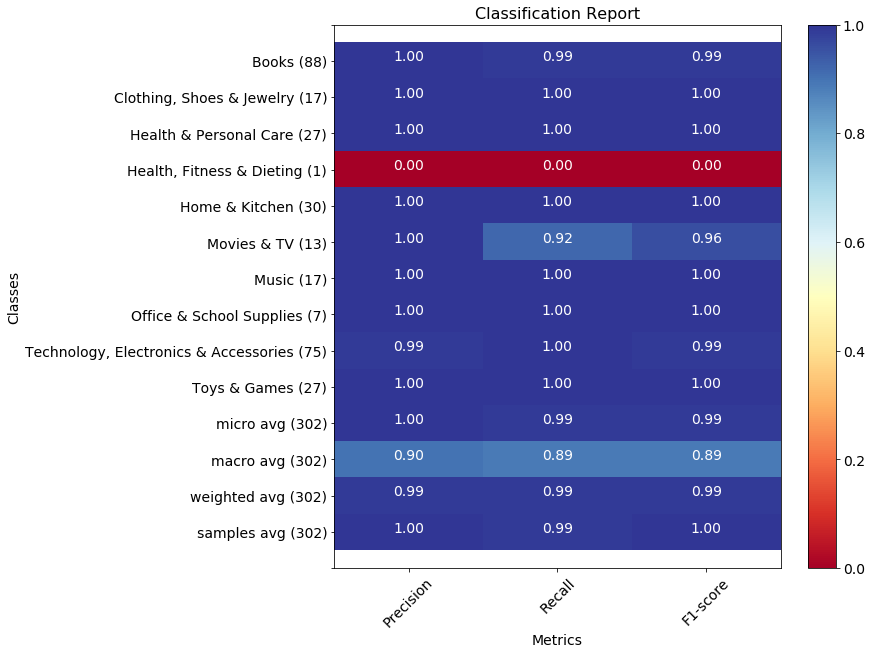

In [344]:
%matplotlib inline

plot_classification_report(cr, classes, save_path="./classification_report.png")